# Malware Detection Model

#Setup

In [10]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH_MALWARE = "/content/drive/MyDrive/Datasets/2malware/Malware-dataset.csv"
DATA_PATH_SPAM = "/content/drive/MyDrive/Datasets/2spam/emails.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#DATA_PATH_MALWARE = "/Datasets/2malware/Malware-dataset.csv"
#DATA_PATH_SPAM = "/Datasets/2spam/emails.csv"

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import seaborn as sns

malware = pd.read_csv(DATA_PATH_MALWARE)

#Preprocessing

In [13]:
from sklearn.preprocessing import LabelEncoder

# ==========================================
# CORRECTED PREPROCESSING - NO DATA LEAKAGE
# ==========================================

print("="*70)
print("CORRECTED PREPROCESSING WITH HASH-BASED SPLITTING")
print("="*70)

# Load original data
malware_original = pd.read_csv(DATA_PATH_MALWARE)

print(f"\nOriginal dataset: {malware_original.shape}")
print(f"Unique hashes: {malware_original['hash'].nunique()}")
print(f"Samples per hash: {len(malware_original) / malware_original['hash'].nunique():.0f}")

# ==========================================
# STEP 1: Split by UNIQUE HASH (Critical!)
# ==========================================

print("\n" + "-"*70)
print("STEP 1: HASH-BASED TRAIN-VAL-TEST SPLIT")
print("-"*70)

from sklearn.model_selection import train_test_split

# Get one representative sample per unique hash
unique_samples = malware_original.groupby('hash').first().reset_index()
print(f"\nUnique samples: {len(unique_samples)}")
print(f"  Malware: {(unique_samples['classification'] == 'malware').sum()}")
print(f"  Benign: {(unique_samples['classification'] == 'benign').sum()}")

# Split unique hashes: 70% train, 15% val, 15% test
hash_train_val, hash_test = train_test_split(
    unique_samples['hash'],
    test_size=0.15,
    random_state=42,
    stratify=unique_samples['classification']
)

hash_train, hash_val = train_test_split(
    hash_train_val,
    test_size=0.176,  # 0.176 of 0.85 ≈ 0.15 of total
    random_state=42,
    stratify=unique_samples[unique_samples['hash'].isin(hash_train_val)]['classification']
)

print(f"\nHash split:")
print(f"  Training hashes: {len(hash_train)}")
print(f"  Validation hashes: {len(hash_val)}")
print(f"  Test hashes: {len(hash_test)}")

# Verify no overlap
assert len(set(hash_train) & set(hash_val)) == 0, "Train-Val hash overlap!"
assert len(set(hash_train) & set(hash_test)) == 0, "Train-Test hash overlap!"
assert len(set(hash_val) & set(hash_test)) == 0, "Val-Test hash overlap!"
print("  ✓ Verified: NO hash overlap between sets")

# Create datasets based on hash splits
train_data = malware_original[malware_original['hash'].isin(hash_train)].copy()
val_data = malware_original[malware_original['hash'].isin(hash_val)].copy()
test_data = malware_original[malware_original['hash'].isin(hash_test)].copy()

print(f"\nDataset sizes (with all millisecond snapshots):")
print(f"  Training: {len(train_data)} samples")
print(f"  Validation: {len(val_data)} samples")
print(f"  Test: {len(test_data)} samples")

# ==========================================
# STEP 2: Feature Engineering
# ==========================================

print("\n" + "-"*70)
print("STEP 2: FEATURE ENGINEERING")
print("-"*70)

def prepare_features(df):
    """Prepare features from dataframe"""
    df_processed = df.copy()

    # Remove identifier columns
    df_processed = df_processed.drop(['hash'], axis=1)

    # Encode target
    le = LabelEncoder()
    y = le.fit_transform(df_processed['classification'])

    # Remove target from features
    X = df_processed.drop('classification', axis=1)

    return X, y, le

# Prepare all splits
X_train, y_train, label_encoder = prepare_features(train_data)
X_val, y_val, _ = prepare_features(val_data)
X_test, y_test, _ = prepare_features(test_data)

print(f"\nFeature shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

print(f"\nClass encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print(f"\nClass distribution:")
print(f"  Train - Benign: {(y_train == 0).sum()}, Malware: {(y_train == 1).sum()}")
print(f"  Val - Benign: {(y_val == 0).sum()}, Malware: {(y_val == 1).sum()}")
print(f"  Test - Benign: {(y_test == 0).sum()}, Malware: {(y_test == 1).sum()}")

# ==========================================
# STEP 3: Feature Scaling (for Logistic Regression)
# ==========================================

print("\n" + "-"*70)
print("STEP 3: FEATURE SCALING")
print("-"*70)

from sklearn.preprocessing import StandardScaler

# Scale features (fit on train only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Scaled features for Logistic Regression")
print("  (Tree-based models will use unscaled data)")

# ==========================================
# OPTIONAL: Use only ONE snapshot per hash
# ==========================================

print("\n" + "-"*70)
print("OPTIONAL: SINGLE SNAPSHOT DATASETS")
print("-"*70)
print("\nCreating simplified datasets with one sample per hash...")

# Take first snapshot (millisecond=0) for each hash
train_single = train_data[train_data['millisecond'] == train_data.groupby('hash')['millisecond'].transform('min')]
val_single = val_data[val_data['millisecond'] == val_data.groupby('hash')['millisecond'].transform('min')]
test_single = test_data[test_data['millisecond'] == test_data.groupby('hash')['millisecond'].transform('min')]

X_train_single, y_train_single, _ = prepare_features(train_single)
X_val_single, y_val_single, _ = prepare_features(val_single)
X_test_single, y_test_single, _ = prepare_features(test_single)

X_train_single_scaled = scaler.fit_transform(X_train_single)
X_val_single_scaled = scaler.transform(X_val_single)
X_test_single_scaled = scaler.transform(X_test_single)

print(f"\nSingle snapshot datasets:")
print(f"  X_train_single: {X_train_single.shape}")
print(f"  X_val_single: {X_val_single.shape}")
print(f"  X_test_single: {X_test_single.shape}")

# ==========================================
# SUMMARY
# ==========================================

print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)

print("\n✓ Data leakage FIXED:")
print("  - Split by unique hash, not by rows")

print("\n Two dataset options prepared:")
print("  1. FULL: All millisecond snapshots (100k samples)")
print("  2. SINGLE: One snapshot per hash (1k samples)")

CORRECTED PREPROCESSING WITH HASH-BASED SPLITTING

Original dataset: (100000, 35)
Unique hashes: 100
Samples per hash: 1000

----------------------------------------------------------------------
STEP 1: HASH-BASED TRAIN-VAL-TEST SPLIT
----------------------------------------------------------------------

Unique samples: 100
  Malware: 50
  Benign: 50

Hash split:
  Training hashes: 70
  Validation hashes: 15
  Test hashes: 15
  ✓ Verified: NO hash overlap between sets

Dataset sizes (with all millisecond snapshots):
  Training: 70000 samples
  Validation: 15000 samples
  Test: 15000 samples

----------------------------------------------------------------------
STEP 2: FEATURE ENGINEERING
----------------------------------------------------------------------

Feature shapes:
  X_train: (70000, 33)
  X_val: (15000, 33)
  X_test: (15000, 33)

Class encoding: {'benign': np.int64(0), 'malware': np.int64(1)}

Class distribution:
  Train - Benign: 37000, Malware: 33000
  Val - Benign: 5000

#Training model and comparing to baseline models

MODEL TRAINING - CORRECTED (NO DATA LEAKAGE)

Using SINGLE SNAPSHOT datasets (one per unique hash)
This properly tests ability to detect UNSEEN malware

----------------------------------------------------------------------
1. LOGISTIC REGRESSION
----------------------------------------------------------------------
Training time: 0.0207 seconds
Inference time: 0.001026 seconds

Validation Metrics:
  Accuracy:  0.8000
  Precision: 1.0000
  Recall:    0.7000
  F1-Score:  0.8235
  ROC-AUC:   1.0000

Confusion Matrix:
[[5 0]
 [3 7]]
False Positives: 0 | False Negatives: 3

----------------------------------------------------------------------
2. DECISION TREE
----------------------------------------------------------------------
Training time: 0.0065 seconds
Inference time: 0.005508 seconds

Validation Metrics:
  Accuracy:  0.6667
  Precision: 0.7778
  Recall:    0.7000
  F1-Score:  0.7368
  ROC-AUC:   0.6500

Confusion Matrix:
[[3 2]
 [3 7]]
False Positives: 2 | False Negatives: 3

-----

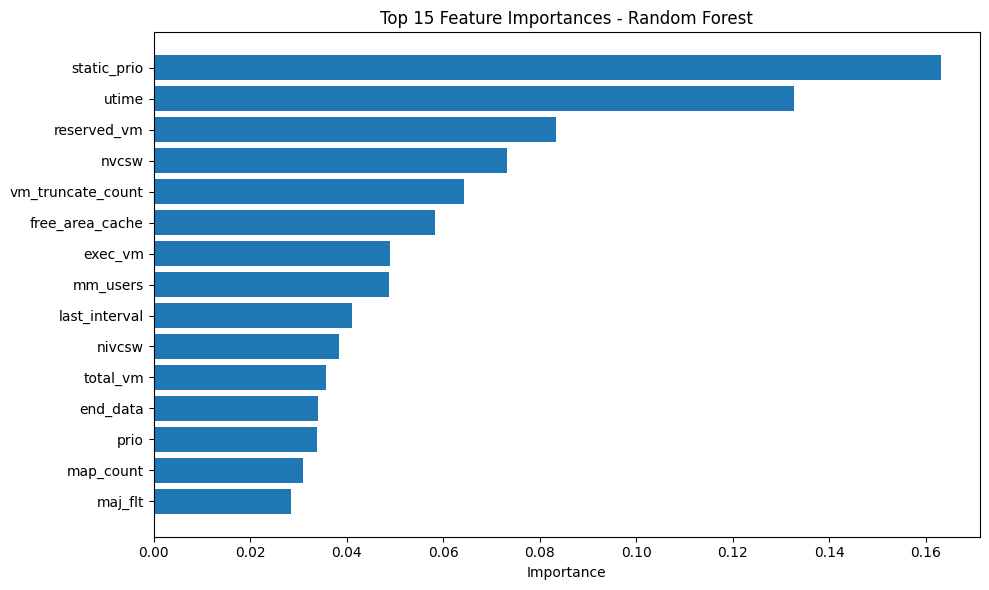


ROC CURVE COMPARISON


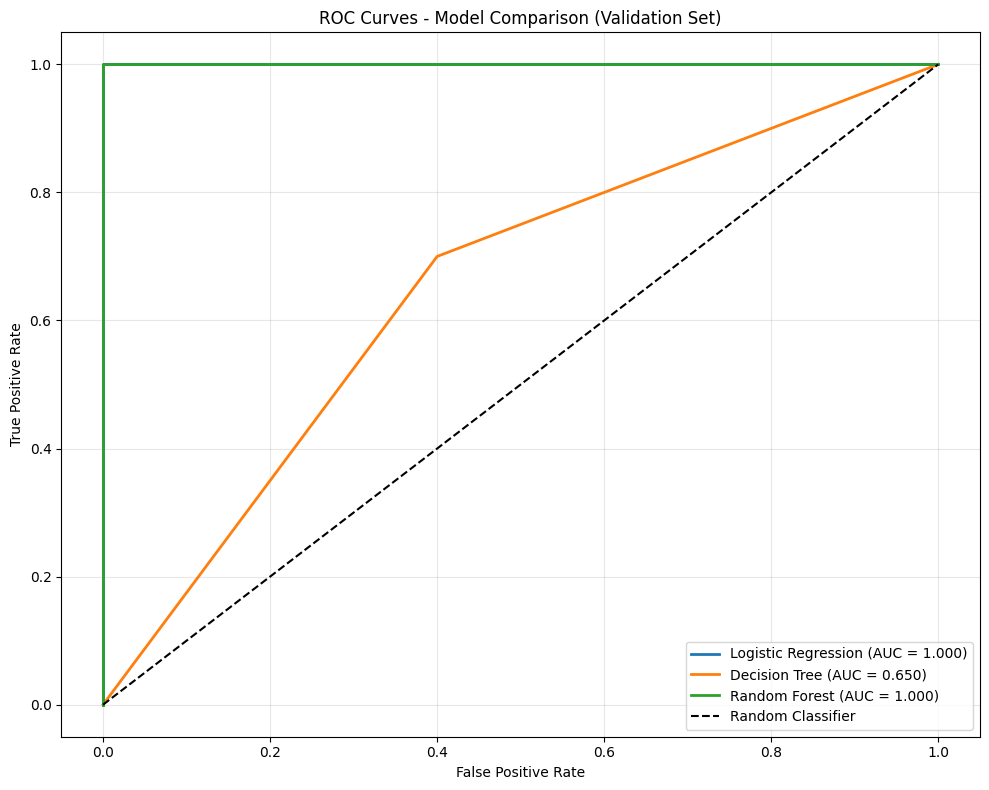


Notes

Best Validation Performance: Random Forest (F1: 0.8889)
Best Test Performance: Random Forest (F1: 1.0000)


In [14]:
# ==========================================
# CORRECTED MODEL TRAINING
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import time
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("MODEL TRAINING - CORRECTED (NO DATA LEAKAGE)")
print("="*70)
print("\nUsing SINGLE SNAPSHOT datasets (one per unique hash)")
print("This properly tests ability to detect UNSEEN malware\n")

# Dictionary to store results
results = {}

# ==========================================
# 1. LOGISTIC REGRESSION
# ==========================================

print("-"*70)
print("1. LOGISTIC REGRESSION")
print("-"*70)

# Train on SCALED data
start_time = time.time()
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_single_scaled, y_train_single)
train_time_lr = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_lr = lr_model.predict(X_val_single_scaled)
y_val_proba_lr = lr_model.predict_proba(X_val_single_scaled)[:, 1]
inference_time_lr = time.time() - start_time

# Calculate metrics
accuracy_lr = accuracy_score(y_val_single, y_val_pred_lr)
precision_lr = precision_score(y_val_single, y_val_pred_lr, zero_division=0)
recall_lr = recall_score(y_val_single, y_val_pred_lr, zero_division=0)
f1_lr = f1_score(y_val_single, y_val_pred_lr, zero_division=0)
roc_auc_lr = roc_auc_score(y_val_single, y_val_proba_lr)

# Store results
results['Logistic Regression'] = {
    'accuracy': accuracy_lr,
    'precision': precision_lr,
    'recall': recall_lr,
    'f1': f1_lr,
    'roc_auc': roc_auc_lr,
    'train_time': train_time_lr,
    'inference_time': inference_time_lr,
    'y_val_pred': y_val_pred_lr,
    'y_val_proba': y_val_proba_lr
}

print(f"Training time: {train_time_lr:.4f} seconds")
print(f"Inference time: {inference_time_lr:.6f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_lr:.4f}")
print(f"  Precision: {precision_lr:.4f}")
print(f"  Recall:    {recall_lr:.4f}")
print(f"  F1-Score:  {f1_lr:.4f}")
print(f"  ROC-AUC:   {roc_auc_lr:.4f}")

cm_lr = confusion_matrix(y_val_single, y_val_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)
tn, fp, fn, tp = cm_lr.ravel()
print(f"False Positives: {fp} | False Negatives: {fn}")

# ==========================================
# 2. DECISION TREE
# ==========================================

print("\n" + "-"*70)
print("2. DECISION TREE")
print("-"*70)

# Train on UNSCALED data (trees don't need scaling)
start_time = time.time()
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_single, y_train_single)
train_time_dt = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_dt = dt_model.predict(X_val_single)
y_val_proba_dt = dt_model.predict_proba(X_val_single)[:, 1]
inference_time_dt = time.time() - start_time

# Calculate metrics
accuracy_dt = accuracy_score(y_val_single, y_val_pred_dt)
precision_dt = precision_score(y_val_single, y_val_pred_dt, zero_division=0)
recall_dt = recall_score(y_val_single, y_val_pred_dt, zero_division=0)
f1_dt = f1_score(y_val_single, y_val_pred_dt, zero_division=0)
roc_auc_dt = roc_auc_score(y_val_single, y_val_proba_dt)

# Store results
results['Decision Tree'] = {
    'accuracy': accuracy_dt,
    'precision': precision_dt,
    'recall': recall_dt,
    'f1': f1_dt,
    'roc_auc': roc_auc_dt,
    'train_time': train_time_dt,
    'inference_time': inference_time_dt,
    'y_val_pred': y_val_pred_dt,
    'y_val_proba': y_val_proba_dt
}

print(f"Training time: {train_time_dt:.4f} seconds")
print(f"Inference time: {inference_time_dt:.6f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_dt:.4f}")
print(f"  Precision: {precision_dt:.4f}")
print(f"  Recall:    {recall_dt:.4f}")
print(f"  F1-Score:  {f1_dt:.4f}")
print(f"  ROC-AUC:   {roc_auc_dt:.4f}")

cm_dt = confusion_matrix(y_val_single, y_val_pred_dt)
print(f"\nConfusion Matrix:")
print(cm_dt)
tn, fp, fn, tp = cm_dt.ravel()
print(f"False Positives: {fp} | False Negatives: {fn}")

# ==========================================
# 3. RANDOM FOREST
# ==========================================

print("\n" + "-"*70)
print("3. RANDOM FOREST")
print("-"*70)

# Train on UNSCALED data
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_single, y_train_single)
train_time_rf = time.time() - start_time

# Predict on validation set
start_time = time.time()
y_val_pred_rf = rf_model.predict(X_val_single)
y_val_proba_rf = rf_model.predict_proba(X_val_single)[:, 1]
inference_time_rf = time.time() - start_time

# Calculate metrics
accuracy_rf = accuracy_score(y_val_single, y_val_pred_rf)
precision_rf = precision_score(y_val_single, y_val_pred_rf, zero_division=0)
recall_rf = recall_score(y_val_single, y_val_pred_rf, zero_division=0)
f1_rf = f1_score(y_val_single, y_val_pred_rf, zero_division=0)
roc_auc_rf = roc_auc_score(y_val_single, y_val_proba_rf)

# Store results
results['Random Forest'] = {
    'accuracy': accuracy_rf,
    'precision': precision_rf,
    'recall': recall_rf,
    'f1': f1_rf,
    'roc_auc': roc_auc_rf,
    'train_time': train_time_rf,
    'inference_time': inference_time_rf,
    'y_val_pred': y_val_pred_rf,
    'y_val_proba': y_val_proba_rf
}

print(f"Training time: {train_time_rf:.4f} seconds")
print(f"Inference time: {inference_time_rf:.6f} seconds")
print(f"\nValidation Metrics:")
print(f"  Accuracy:  {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  ROC-AUC:   {roc_auc_rf:.4f}")

cm_rf = confusion_matrix(y_val_single, y_val_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)
tn, fp, fn, tp = cm_rf.ravel()
print(f"False Positives: {fp} | False Negatives: {fn}")

# ==========================================
# 4. MODEL COMPARISON
# ==========================================

print("\n" + "="*70)
print("MODEL COMPARISON - VALIDATION SET")
print("="*70)

comparison_df = pd.DataFrame(results).T
comparison_df_metrics = comparison_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].round(4)
comparison_df_time = comparison_df[['train_time', 'inference_time']].round(6)

print("\nPerformance Metrics:")
print(comparison_df_metrics)

print("\n\nTraining & Inference Times:")
print(comparison_df_time)

print("\n\nBest Model per Metric:")
print(f"  Best Accuracy:  {comparison_df['accuracy'].idxmax()} ({comparison_df['accuracy'].max():.4f})")
print(f"  Best Precision: {comparison_df['precision'].idxmax()} ({comparison_df['precision'].max():.4f})")
print(f"  Best Recall:    {comparison_df['recall'].idxmax()} ({comparison_df['recall'].max():.4f})")
print(f"  Best F1-Score:  {comparison_df['f1'].idxmax()} ({comparison_df['f1'].max():.4f})")
print(f"  Best ROC-AUC:   {comparison_df['roc_auc'].idxmax()} ({comparison_df['roc_auc'].max():.4f})")

# ==========================================
# 5. TEST SET EVALUATION
# ==========================================

print("\n" + "="*70)
print("FINAL EVALUATION - TEST SET (UNSEEN MALWARE)")
print("="*70)

test_results = {}

for model_name, model in [('Logistic Regression', lr_model),
                          ('Decision Tree', dt_model),
                          ('Random Forest', rf_model)]:
    print(f"\n{model_name}:")
    print("-" * 40)

    # Use appropriate data (scaled for LR, unscaled for trees)
    if model_name == 'Logistic Regression':
        X_test_use = X_test_single_scaled
    else:
        X_test_use = X_test_single

    # Predictions
    y_test_pred = model.predict(X_test_use)
    y_test_proba = model.predict_proba(X_test_use)[:, 1]

    # Metrics
    test_acc = accuracy_score(y_test_single, y_test_pred)
    test_prec = precision_score(y_test_single, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test_single, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test_single, y_test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test_single, y_test_proba)

    test_results[model_name] = {
        'accuracy': test_acc,
        'precision': test_prec,
        'recall': test_rec,
        'f1': test_f1,
        'roc_auc': test_auc
    }

    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-Score:  {test_f1:.4f}")
    print(f"ROC-AUC:   {test_auc:.4f}")

    cm = confusion_matrix(y_test_single, y_test_pred)
    print(f"Confusion Matrix:\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positives: {fp} | False Negatives: {fn}")

# ==========================================
# 6. FEATURE IMPORTANCE
# ==========================================

print("\n" + "="*70)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X_train_single.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ==========================================
# 7. ROC CURVES
# ==========================================

print("\n" + "="*70)
print("ROC CURVE COMPARISON")
print("="*70)

plt.figure(figsize=(10, 8))

for model_name in ['Logistic Regression', 'Decision Tree', 'Random Forest']:
    # Use validation predictions
    y_proba = results[model_name]['y_val_proba']
    fpr, tpr, _ = roc_curve(y_val_single, y_proba)
    auc = results[model_name]['roc_auc']

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison (Validation Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==========================================
# SUMMARY
# ==========================================

print("\n" + "="*70)
print("Notes")
print("="*70)

val_f1_scores = {k: v['f1'] for k, v in results.items()}
test_f1_scores = {k: v['f1'] for k, v in test_results.items()}

best_val_model = max(val_f1_scores, key=val_f1_scores.get)
best_test_model = max(test_f1_scores, key=test_f1_scores.get)

print(f"\nBest Validation Performance: {best_val_model} (F1: {val_f1_scores[best_val_model]:.4f})")
print(f"Best Test Performance: {best_test_model} (F1: {test_f1_scores[best_test_model]:.4f})")

#Evaluation

In [15]:
# ==========================================
# CRITICAL VALIDATION: TEST SET EVALUATION
# ==========================================

print("="*60)
print("TEST SET EVALUATION - FINAL VALIDATION")
print("="*60)
print("\n⚠️  Perfect validation scores are suspicious!")
print("Let's evaluate on the completely unseen test set...\n")

# ==========================================
# Evaluate all three models on TEST set
# ==========================================

models_dict = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

test_results = {}

for model_name, model in models_dict.items():
    print("-"*60)
    print(f"{model_name} - Test Set Performance")
    print("-"*60)

    # Predictions
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)

    test_results[model_name] = {
        'accuracy': test_acc,
        'precision': test_prec,
        'recall': test_rec,
        'f1': test_f1,
        'roc_auc': test_auc
    }

    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-Score:  {test_f1:.4f}")
    print(f"ROC-AUC:   {test_auc:.4f}")
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    # Calculate False Positive Rate
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    print(f"False Positive Rate: {fpr:.4f} ({fp} false alarms)")
    print(f"False Negative Rate: {fnr:.4f} ({fn} missed threats)\n")

# ==========================================
# Compare Validation vs Test Performance
# ==========================================

print("="*60)
print("VALIDATION vs TEST SET COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Val_F1': [results['Logistic Regression']['f1'],
               results['Decision Tree']['f1'],
               results['Random Forest']['f1']],
    'Test_F1': [test_results['Logistic Regression']['f1'],
                test_results['Decision Tree']['f1'],
                test_results['Random Forest']['f1']],
    'Val_Accuracy': [results['Logistic Regression']['accuracy'],
                     results['Decision Tree']['accuracy'],
                     results['Random Forest']['accuracy']],
    'Test_Accuracy': [test_results['Logistic Regression']['accuracy'],
                      test_results['Decision Tree']['accuracy'],
                      test_results['Random Forest']['accuracy']]
})

print("\n", comparison)

# Check for overfitting
print("\n" + "="*60)
print("OVERFITTING CHECK")
print("="*60)

for model_name in test_results.keys():
    val_f1 = results[model_name]['f1']
    test_f1 = test_results[model_name]['f1']
    diff = val_f1 - test_f1

    print(f"\n{model_name}:")
    print(f"  Validation F1: {val_f1:.4f}")
    print(f"  Test F1:       {test_f1:.4f}")
    print(f"  Difference:    {diff:.4f}")

    if abs(diff) < 0.01:
        print("  ✓ Consistent performance - no overfitting detected")
    elif diff > 0.05:
        print("  ⚠️  OVERFITTING - model performs worse on test set")
    else:
        print("  ℹ️  Slight difference - acceptable variation")

TEST SET EVALUATION - FINAL VALIDATION

⚠️  Perfect validation scores are suspicious!
Let's evaluate on the completely unseen test set...

------------------------------------------------------------
Logistic Regression - Test Set Performance
------------------------------------------------------------
Accuracy:  0.8679
Precision: 0.8408
Recall:    0.8843
F1-Score:  0.8620
ROC-AUC:   0.8704

Confusion Matrix:
[[6828 1172]
 [ 810 6190]]
False Positive Rate: 0.1465 (1172 false alarms)
False Negative Rate: 0.1157 (810 missed threats)

------------------------------------------------------------
Decision Tree - Test Set Performance
------------------------------------------------------------
Accuracy:  0.4667
Precision: 0.4667
Recall:    1.0000
F1-Score:  0.6364
ROC-AUC:   0.5000

Confusion Matrix:
[[   0 8000]
 [   0 7000]]
False Positive Rate: 1.0000 (8000 false alarms)
False Negative Rate: 0.0000 (0 missed threats)

------------------------------------------------------------
Random For

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [16]:
# ==========================================
# EXPORT MALWARE DETECTION MODELS
# ==========================================

import pickle
import os

# Create directory for models
os.makedirs('malware_models', exist_ok=True)

print("="*70)
print("EXPORTING MALWARE DETECTION MODELS")
print("="*70)

# Save Random Forest model
with open('malware_models/malware_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest model saved")

# Save feature scaler
with open('malware_models/malware_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Feature scaler saved")

# Save label encoder
with open('malware_models/malware_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label encoder saved")

# Save feature names for validation
feature_names = list(X_train_single.columns)
with open('malware_models/malware_features.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print(f"✓ Feature names saved ({len(feature_names)} features)")

# Verify files
print("\n" + "="*70)
print("VERIFICATION")
print("="*70)

model_files = os.listdir('malware_models')
print(f"\nFiles created: {len(model_files)}")
for file in sorted(model_files):
    filepath = os.path.join('malware_models', file)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"  ✓ {file} ({size:.2f} KB)")

# Create zip file
import shutil
shutil.make_archive('malware_models', 'zip', 'malware_models')
print("\n✓ Created 'malware_models.zip'")

# Download from Colab
from google.colab import files
files.download('malware_models.zip')
print("✓ Download started - check your browser downloads")

print("\n" + "="*70)
print("MALWARE MODELS EXPORT COMPLETE!")
print("="*70)

EXPORTING MALWARE DETECTION MODELS
✓ Random Forest model saved
✓ Feature scaler saved
✓ Label encoder saved
✓ Feature names saved (33 features)

VERIFICATION

Files created: 4
  ✓ malware_features.pkl (0.40 KB)
  ✓ malware_label_encoder.pkl (0.26 KB)
  ✓ malware_rf_model.pkl (207.05 KB)
  ✓ malware_scaler.pkl (1.69 KB)

✓ Created 'malware_models.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download started - check your browser downloads

MALWARE MODELS EXPORT COMPLETE!
